# Calculating the Effective Hill Coefficient

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
import seaborn as sns

import mwc_induction_utils as mwc
mwc.set_plotting_style()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In the MWC paper, we discuss several features of induction curves that can be gleaned from our model. One of these, the effective hill coefficient, quanitfies the slope of the plot at the EC50. Unfortunately, the effective hill coefficient is quite difficult to solve for analytically. I propose simply using the slope rather than the Hill coefficient, as this can be evaluated much more easily. 

I will demonstrate here how the slope can be calculated generally and then verify that it works for the theory curves of several different strains. 

The slope that interests us is the linear region when fold-change is plotted against the log of the concentration, shown below for O3 and R = 260.

In [2]:
# Define parameters
IPTG = np.logspace(-8, -2, 200) * 10**6
Ka = 141.52
Ki = 0.56061
reps = 260
epsilon = 4.5
O3 = -9.7
e_p = -5.4
P = 3000

In [3]:
# Functions for calculating fold change

def pact(IPTG, Ka, Ki, epsilon):
    pact = (1 + IPTG * 1 / Ka)**2 / \
    (((1 + IPTG * 1 / Ka))**2 + np.exp(-epsilon) * (1 + IPTG * 1 / Ki)**2)
    return pact

def fold_change(IPTG, Ka, Ki, epsilon, R, epsilon_r):
    return 1 / (1 + R / 5E6 * pact(IPTG, Ka, Ki, epsilon) * \
            (1 + np.exp(-epsilon)) * np.exp(-epsilon_r))

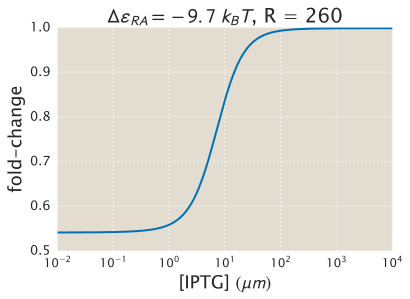

In [4]:
plt.semilogx(IPTG, fold_change(IPTG=IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=reps, epsilon_r=O3))

plt.title(r'$\Delta \varepsilon_{RA} = -9.7\ k_BT$, R = 260')
plt.xlabel(r'[IPTG] $(\mu m)$')
plt.ylabel('fold-change')

We need to differentiate fold-change, therefore, with respect to the log of concentration. Let us define a variable $C = \log{c}$. When we substitute this into the fold-change equation we get

\begin{equation}
\mathrm{fc} = \left( 1 + \frac{\left( 1 + \frac{e^C}{K_A} \right)^2}{\left( 1 + \frac{e^C}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}} \left( 1 + \frac{e^C}{K_I} \right)^2} \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \right)^{-1}.
\end{equation}

To obtain the slope of this function, we differentiate with respect to $C$, giving us

\begin{equation}
\frac{\partial \mathrm{fc}}{\partial C} = -\mathrm{fc}^2 \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \frac{2 e^{C} e^{-\beta \Delta \varepsilon_{AI}} \left[\frac{1}{K_A} \left( 1 + \frac{e^C}{K_A} \right) \left( 1 + \frac{e^C}{K_I} \right)^2 - \frac{1}{K_I} \left( 1 + \frac{e^C}{K_A} \right)^2 \left( 1 + \frac{e^C}{K_I} \right)\right]}{\left[ \left( 1 + \frac{e^C}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}} \left( 1 + \frac{e^C}{K_I} \right)^2 \right]^2},
\end{equation}

where to save space "$\mathrm{fc}$" is used to denote the portion of the equation that is equal to the original fold-change equation. Converting back to the concentration variable $c$ gives us

\begin{equation}
\mathrm{slope} = -\mathrm{fc}^2 \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \frac{2 c e^{-\beta \Delta \varepsilon_{AI}} \left[\frac{1}{K_A} \left( 1 + \frac{c}{K_A} \right) \left( 1 + \frac{c}{K_I} \right)^2 - \frac{1}{K_I} \left( 1 + \frac{c}{K_A} \right)^2 \left( 1 + \frac{c}{K_I} \right)\right]}{\left[ \left( 1 + \frac{c}{K_A} \right)^2 + e^{-\beta \Delta \varepsilon_{AI}} \left( 1 + \frac{c}{K_I} \right)^2 \right]^2},
\end{equation}

Evaluating this equation at $c = EC_{50}$ gives us the slope of the linear portion of the curve. The $EC_{50}$ is given by the concentration at which

\begin{equation}
\mathrm{fc}\left(EC_{50} \right) = \frac{1}{2}\left(\mathrm{fc}\left(c=0 \right) + \mathrm{fc}\left(c \rightarrow \infty \right)\right).
\end{equation}

The $EC_{50}$ evaluates to 

\begin{equation}
EC_{50} = K_A \left( \frac{ \frac{K_A}{K_I} -1}{\frac{K_A}{K_I} - \left( \frac{1 + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} + \left( \frac{K_A}{K_I} \right)^n \left( 2 e^{-\beta \Delta \varepsilon_{AI}} + 1 + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}}\right)}{2 \left( 1 + \frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}} \right) + e^{-\beta \Delta \varepsilon_{AI}} + \left( \frac{K_A}{KI} \right)^n e^{-\beta \Delta \varepsilon_{AI}}} \right)^{\frac{1}{n}}} -1 \right).
\end{equation}

The $EC_{50}$ and slope of the linear region are plotted for O3 with $R = 260$ below.

In [5]:
# Write a formula for EC50 and slope

def EC50(Ka, Ki, epsilon, R, epsilon_r):
    t = 1 + (R / 5E6) * np.exp(-epsilon_r) + (Ka / Ki)**2 * (2 * np.exp(-epsilon) + 1 + (R / 5E6) * np.exp(-epsilon_r))
    b = 2 * (1 + (R / 5E6) * np.exp(-epsilon_r)) + np.exp(-epsilon) + (Ka / Ki)**2 * np.exp(-epsilon)
    return Ka * ((Ka / Ki - 1)/(Ka / Ki - (t/b)**(1/2)) -1)

def log_slope(c, Ka, Ki, epsilon, R, epsilon_r):
    return (-(fold_change(c, Ka, Ki, epsilon, R, epsilon_r))**2 * R / 5E6 * np.exp(-epsilon_r) * \
            2 * c * np.exp(-epsilon) * (1/Ka * (1 + c/Ka) * (1 + c/Ki)**2 - \
                                              1/Ki * (1 + c/Ka)**2 * (1 + c/Ki)) / \
           ((1 + c/Ka)**2 + np.exp(-epsilon) * (1 + c/Ki)**2)**2)

# To plot a line, we also need the y-intercept. 
# We can calculate this from the observation that c = EC50 when fc = 1/2 (max - min)

def intercept(EC, slope, Ka, Ki, epsilon, R, epsilon_r):
    maximum = 1/(1 + 1/(1 + np.exp(-epsilon) * (Ka/Ki)**2) * R/5E6 * np.exp(-epsilon_r))
    minimum = 1/(1 + 1/(1 + np.exp(-epsilon)) * R/5E6 * np.exp(-epsilon_r))
    
    y = (maximum + minimum)/2
    
    return y - slope*EC



(0.5, 1.05)

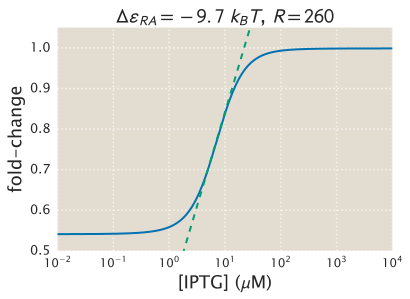

In [13]:
# This shows a comparison of the plot and the calculated line

EC = EC50(Ka, Ki, epsilon, reps, O3)
slope = log_slope(EC, Ka, Ki, epsilon, reps, O3)
inter = intercept(np.log(EC), slope, Ka, Ki, epsilon, reps, O3)

plt.semilogx(IPTG, fold_change(IPTG, Ka=Ka, Ki=Ki, epsilon=epsilon, R=reps, epsilon_r=O3))
plt.semilogx(IPTG, slope * np.log(IPTG) + inter, ls = '--')
plt.title(r'$\Delta \varepsilon_{RA} = -9.7\ k_BT$, $R = 260$')
plt.xlabel(r'[IPTG] ($\mu$M)')
plt.ylabel('fold-change')

axes = plt.gca()
axes.set_ylim(0.5, 1.05)